In [42]:
import numpy
import scipy.sparse
import scipy.linalg
from matplotlib import pyplot as plt

In [43]:
def generate_mesh(x_min, x_max, n_cells):
    """Generates a uniform mesh of n_cells on the interval [x_min, x_max].

    Generates a uniform mesh with n_cells on the interval [x_min, x_max].
    A (1D) mesh is a collection of (n_cells + 1) points (vertices) and a 
    list of n_cells pairs of indices of two vertices defining the cells.

    The k-th mesh vertex, x_k, is given by
        x_k = x_min + k delta_x, k = 0, ..., n

    where
        delta_x = (x_max - x_min)/n_cells 

    The k-th cell of the mesh is
        c_k = [k, k + 1]
        
    meaning that cell k is bounded by vertex k and vertex (k+1).

    Parameters
    ----------
    x_min : float
        The lower bound of the interval over which the mesh will be generated.
    x_max : float
        The upper bound of the interval over which the mesh will be generated.
    n_cells : int
        The number of cells of the mesh.

    Returns
    -------
    vertices: numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells: numpy.array(int), size [n, 2]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell
    """

    # Make some quantities more clear
    n_vertices = n_cells + 1

    # Generate the vertices
    vertices = numpy.linspace(x_min, x_max, n_vertices)

    # Generate the cells
    cells = numpy.zeros([n_cells, 2], dtype=numpy.int64)
    cells[:, 0] = numpy.arange(0, n_vertices - 1)  # the index of the lower bound vertex of the cell
    cells[:, 1] = numpy.arange(1, n_vertices)  # the index of the lower bound vertex of the cell

    return vertices, cells

def generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y):
    """Generates a uniform mesh of n_cells_x x n_cells_y on the domain [x_min, x_max] x [y_min, y_max].

    Generates a uniform mesh with n_cells_x x n_cells_y on the domain [x_min, x_max] x [y_min, y_max].
    A (2D) mesh is a collection of (n_cells_x + 1) x (n_cells_y + 1) points (vertices) and a 
    list of n_cells_x x n_cells_y pairs of indices of fours vertices defining the cells.

    The vertices of each cell are given in the following order
    
    3          4
     X ------ X
     |        |
     |        |
     X ------ X
    1          2
 
    The vertex (i, j) of the mesh is given by
        V_{i,j} = [x_min + i delta_x, y_min + j delta_y], i = 0, ..., (n_cells_x + 1), j = 0, ..., (n_cells_y + 1)

    and its single index is given by
        V_{k = i + (n_cells_x + 1)*j} = V_{i, j}

    where
        delta_x = (x_max - x_min)/n_cells_x
        delta_y = (y_max - y_min)/n_cells_y 

    The cell (i, j) of the mesh is given by
        c_{i,j} = [V_{i,j}, V_{i+1, j}, V_{i, j+1}, V_{i+1, j+1}]

    and its single index is given by
        c_{k = i + n_cells_x*j} = c_{i, j}.

    Parameters
    ----------
    x_min : float
        The lower bound of the x interval over which the mesh will be generated.
    x_max : float
        The upper bound of the x interval over which the mesh will be generated.
    y_min : float
        The lower bound of the y interval over which the mesh will be generated.
    y_max : float
        The upper bound of the y interval over which the mesh will be generated.   
    n_cells_x : int
        The number of cells of the mesh in the x-direction.
    n_cells_y : int
        The number of cells of the mesh in the y-direction.

    Returns
    -------
    vertices: numpy.array(float), size [(n_cells_x + 1)*(n_cells_x + 1), 2]
        The x- and y-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x- and y-coordinate of the
        k-th vertex of the mesh, with k given as above V_{k = i + (n_cells_x + 1)*j} = V_{i, j}.
    cells: numpy.array(int), size [n_cells_x * n_cells_x, 4]
        The indices of the four vertices of each cell of the mesh in the order specified above, i.e.,
        cells[k, 0] is the lower left vertex of the k-th cell
        cells[k, 1] is the lower right vertex of the k-th cell
        cells[k, 2] is the upper left vertex of the k-th cell
        cells[k, 3] is the upper right vertex of the k-th cell
        Again, recall the relation between the linear indexing k and the tuple indexing (i,j),
            k = i + n_cells_x * j
    """

    # Make some quantities more clear
    n_vertices_x = n_cells_x + 1
    n_vertices_y = n_cells_y + 1
    n_cells = n_cells_x * n_cells_y

    # Generate the vertices
    x, y = numpy.meshgrid(numpy.linspace(x_min, x_max, n_vertices_x), numpy.linspace(y_min, y_max, n_vertices_y))
    vertices = numpy.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

    # Generate the cells
    cells = numpy.zeros([n_cells, 4], dtype=numpy.int64)
    for j in range(0, n_cells_y):
        for i in range(0, n_cells_x):
            k = i + n_cells_x*j  # the linear cell number
            
            # Now we add the linear index of the vertices of the cell
            # Recall that the vertices of each cell are given in the following order
            #
            #  3          4
            #   X ------ X
            #   |        |
            #   |        |
            #   X ------ X
            #  1          2
            #
            # The vertex (i, j) of the mesh is given by
            # V_{i,j} = [x_min + i delta_x, y_min + j delta_y], i = 0, ..., (n_cells_x + 1), j = 0, ..., (n_cells_y + 1)
            #
            # The cell k = i + n_cells_x(j - 1) of the mesh is given by
            #   c[k, :] = [V_{i,j}, V_{i+1, j}, V_{i, j+1}, V_{i+1, j+1}]
            cells[k, 0] = (i) + (n_cells_x + 1)*(j)  # the linear index of the lower left corner of the element
            cells[k, 1] = (i+1) + (n_cells_x + 1)*(j)  # the linear index of the lower right corner of the element
            cells[k, 2] = (i) + (n_cells_x + 1)*(j+1)  # the linear index of the upper left corner of the element
            cells[k, 3] = (i+1) + (n_cells_x + 1)*(j+1)  # the linear index of the upper right corner of the element

    print(n_cells_x, n_cells_y)
    h_x = (x_max - x_min) / n_cells_x
    h_y = (y_max - y_min) / n_cells_y
    return vertices, cells, h_x, h_y

In [44]:
def evaluate_local_basis_1D(xi):
    """Evaluates the two 1D element basis in the local element [0, 1].

    Evaluates the two 1D element basis in the local element [0, 1], at the
    points xi. The points xi must be in the interval [0, 1].

    Since there are two basis the output B_local will be an array such that
        - B_local[0, :] is the evaluation of the first basis over the points xi
        - B_local[1, :] is the evaluation of the second basis over the points xi
         
    The basis are:
        - B_local_0(x): 1 - x
        - B_local_1(x): x
        
    Parameters
    ----------
    xi : numpy.array(float), size [1, n]
        The points in the interval [0, 1] where to evaluate the basis functions.

    Returns
    -------
    B_local : numpy.array(float), size [2, n]
        The two local basis evaluated at the points xi.
    """

    # Allocate memory for the basis
    B_local = numpy.zeros([2, xi.shape[0]])

    # Compute the basis at the xi points
    B_local[0, :] = 1.0 - xi 
    B_local[1, :] = xi

    return B_local


def evaluate_local_basis_1D_d_dx(xi):
    """Evaluates the derivative of the two 1D element basis in the local element [0, 1].

    Evaluates the derivative of the two 1D element basis in the local element [0, 1], at the
    points xi. The points xi must be in the interval [0, 1].

    Since there are two basis the output B_local_d_dx will be an array such that
        - B_local_d_dx[0, :] is the evaluation of the derivative of the first basis over the points xi
        - B_local_d_dx[1, :] is the evaluation of the derivative of the  second basis over the points xi
         
    The basis are:
        - B_local_0(x): 1 - x
        - B_local_1(x): x

    Therefore the derivatives are:
        - B_local_0_d_dx(x): -1.0
        - B_local_1_d_dx(x): 1.0
        
    Parameters
    ----------
    xi : numpy.array(float), size [1, n]
        The points in the interval [0, 1] where to evaluate the basis functions.

    Returns
    -------
    B_local_d_dx : numpy.array(float), size [2, n]
        The derivative of the two local basis evaluated at the points xi.
    """

    # Allocate memory for the basis
    B_local_d_dx = numpy.zeros([2, xi.shape[0]])

    # Compute the basis at the xi points
    B_local_d_dx[0, :] = -numpy.ones_like(xi) 
    B_local_d_dx[1, :] = numpy.ones_like(xi)

    return B_local_d_dx

In [45]:
def evaluate_function(u, vertices, cells, n_points_per_cell = 2):
    """Evaluates a FEM function with coefficients u on a mesh of vertices and cells.

    Based on the coefficients u and the mesh, compute the FEM function:
        u_eval = \sum_{k=0}^{n} u_{i} B_{i}(x)
    
    The evaluation is made per element. This is not the most efficient way to evaluate
    a FEM function for linear basis. You can just use the coefficients.
        
    Parameters
    ----------
    u : numpy.array(float), size [1, n+1]
        The coefficients of the expansion of the function u to evaluate.
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell
    n_points_per_cell : [optional] int, default 2
        The number of points on which to evaluate u in each cell. The default (2)
        is sufficient for linear basis. This is added, for the general case.

    Returns
    -------
    u_eval : numpy.array(float), size [n, n_points_per_cell]
        The evaluation of u at each of the n cells over the n_points_per_cell points inside each cell.
    x_eval : numpy.array(float), size [n, n_points_per_cell]
        The global points where u_eval is evaluated. Needed for plotting.
    """

    # Determine information on the mesh
    n_cells = cells.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    # Plot the basis B_k (combination of the different parts over the cells)
    xi = numpy.linspace(0, 1, n_points_per_cell)  
    u_eval = numpy.zeros([n_cells, n_points_per_cell])  # allocate the space where to store the basis evaluated at each cell
    x_eval = numpy.zeros([n_cells, n_points_per_cell])  # allocate the space where to store the global coordinates of where the basis are evaluated

    B_local_basis = evaluate_local_basis_1D(xi)  # this is the basis evaluated at the point inside each k-element at the points
                                                        #     xi*(delta_x) + vertices[cells[k, 0]]
                                                        # with delta_x the cell size
    
    for cell_idx, cell in enumerate(cells):
        x_eval[cell_idx, :] = xi * delta_x[cell_idx] + vertices[cell[0]]  # convert the local xi coordinates in the cell into global x coordinates
        u_eval[cell_idx, :] = u[cell] @ B_local_basis  # compute the linear combination of basis based on the coefficients
                                                           # associated to the vertices of the cell
        
    return u_eval, x_eval


def evaluate_function_d_dx(u, vertices, cells, n_points_per_cell = 2):
    """Evaluates the derivative of a FEM function with coefficients u on a mesh of vertices and cells.

    Based on the coefficients u and the mesh, compute the FEM function:
        u_eval = \sum_{k=0}^{n} u_{i} dB_{i}(x)/dx
    
    The evaluation is made per element. This is not the most efficient way to evaluate
    the derivative of a FEM function for linear basis. You can just use the coefficients
    and compute differences.
        
    Parameters
    ----------
    u : numpy.array(float), size [1, n+1]
        The coefficients of the expansion of the function u to evaluate.
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell
    n_points_per_cell : [optional] int, default 2
        The number of points on which to evaluate u in each cell. The default (2)
        is sufficient for linear basis. This is added, for the general case.

    Returns
    -------
    u_d_dx_eval : numpy.array(float), size [n, n_points_per_cell]
        The evaluation of the derivative of u at each of the n cells over the n_points_per_cell points inside each cell.
    x_eval : numpy.array(float), size [n, n_points_per_cell]
        The global points where u_eval is evaluated. Needed for plotting.
    """

    # Determine information on the mesh
    n_cells = cells.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    # Plot the basis B_k (combination of the different parts over the cells)
    xi = numpy.linspace(0, 1, n_points_per_cell)  
    u_d_dx_eval = numpy.zeros([n_cells, n_points_per_cell])  # allocate the space where to store the basis evaluated at each cell
    x_eval = numpy.zeros([n_cells, n_points_per_cell])  # allocate the space where to store the global coordinates of where the basis are evaluated

    B_local_basis_d_dx = evaluate_local_basis_1D_d_dx(xi)  # this is the basis evaluated at the point inside each k-element at the points
                                                        #     xi*(delta_x) + vertices[cells[k, 0]]
                                                        # with delta_x the cell size
    
    for cell_idx, cell in enumerate(cells):
        x_eval[cell_idx, :] = xi * delta_x[cell_idx] + vertices[cell[0]]  # convert the local xi coordinates in the cell into global x coordinates
        u_d_dx_eval[cell_idx, :] = u[cell] @ B_local_basis_d_dx / delta_x[cell_idx]  # compute the linear combination of basis based on the coefficients
                                                                                    # associated to the vertices of the cell
                                                                                    # NOTE: here we need to divide by the cell size
                                                                                    # this is because the local basis is evaluated
                                                                                    # on the interval [0, 1] but we need it on the interval [x_i, x_{i+1}]
                                                                                    # so the derivative needs to be done for the change of variables from xi to x,
                                                                                    # this results in the delta_x term added.
        
    return u_d_dx_eval, x_eval

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\693338004.py:2: SyntaxWarning: invalid escape sequence '\s'
  """Evaluates a FEM function with coefficients u on a mesh of vertices and cells.
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\693338004.py:56: SyntaxWarning: invalid escape sequence '\s'
  """Evaluates the derivative of a FEM function with coefficients u on a mesh of vertices and cells.


In [46]:
def compute_local_mass_matrix():
    """Computes the local mass matrix, for the reference cell [0, 1].

    The local mass matrix M_local is
        M_local[i, j] = \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi
    
    With B_{i}(xi) the local basis function i over the reference cell.

    Since all cells are just an affine rescalling of the reference cell [0, 1],
    a fast way to compute the inner products between all basis is to compute
    first the local inner product on the reference cell and then simply 
    multiply by the required scalling factor due to the coordinate transformation
    to go from the reference cell to the actual cell.
        
    Parameters
    ----------
    None

    Returns
    -------
    M_local : numpy.array(float), size [2, 2]
        The local mass matrix (on the reference cell) with M_local[i, j] ~= \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi
    """

    # The local mass matrix is given by
    #   M_{local} = <B_{i}, B_{j}> = \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi, i,j = 0,1
    # we can approximate this with Gauss-Lobatto quadrature by
    #   \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi ~= 0.5 * B_{i}(xi_{k})B_{j}(xi_{k}) + 0.5* B_{i}(xi_{k})B_{j}(xi_{k}), i,j = 0,1
    # with x_{0} = 0.0, and x_{1} = 1.0. Given the expressions of the basis, we have that
    #   B_{i}(x_{k}) = \delta_{ik}  the Kronecker-delta
    # This allows us to further simplify this expression to
    #   \int_{0}^{1} B_{i}(xi) B_{j}(xi) dxi ~= 0.5

    M_local = numpy.ones([2, 2])
    M_local[0, 0] = -1.0
    M_local[1, 1] = -1.0
    #print("M_local", M_local)
    return M_local

def compute_local_mass_matrix_2D():
    """Computes the local mass matrix, for the 2D reference cell [0, 1] x [0, 1].

    The local mass matrix M_local is
        M_local[k, l] = \int_{0}^{1} \int_{0}^{1} B_{k}(xi, eta) B_{l}(xi, eta) dxi deta
    
    With B_{k}(xi, eta) the local basis function k over the 2D reference cell.

    As before, since all cells are just an affine rescalling of the reference cell [0, 1] x [0, 1],
    a fast way to compute the inner products between all basis is to compute
    first the local inner product on the reference cell and then simply 
    multiply by the required scalling factor due to the coordinate transformation
    to go from the reference cell to the actual cell.

    Another improvement is to note that the basis in 2D are just the tensor product of
    1D basis:
        B_{k}(xi, eta) = B_{i}(xi) B_{j}(eta)
    with the linear index k given by:
        k = i + 2*j

    This means that:
        M_local[k, l] = \int_{0}^{1} B_{i}(xi) B_{r}(xi) dxi *  \int_{0}^{1} B_{j}(eta) B_{s}(eta) deta
    with the linear indices k and l given by:
        k = i + 2*j
        l = r + 2*s

    We can go one step further and recall that the 1D M_local_1D matrix entries are just the 1D integrals we see
    in the expression above, therefore we can write:
        M_local[k, l] = M_local_1D[i, r] * M_local_1D[j, s]
    
    Note that now our M_local is a 4 x 4 matrix, since there are 4 basis per element (one per vertex).
    Parameters
    ----------
    None

    Returns
    -------
    M_local : numpy.array(float), size [4, 4]
        The local mass matrix (on the reference cell) with 
        M_local[k, l] ~= \int_{0}^{1} \int_{0}^{1} B_{k}(xi, eta) B_{l}(xi, eta) dxi deta
    """

    # Following the algorithm described above, we first compute the local 1D mass matrix
    M_local_1D = compute_local_mass_matrix()

    # Populate the 2D M_local matrix
    M_local = numpy.zeros([4, 4])
    for i in range(0, 2):
        for j in range(0, 2):
            for r in range(0, 2):
                for s in range(0, 2):
                    # Compute the linear indices of the basis
                    k = i + 2*j
                    l = r + 2*s

                    # Compute the 2D inner product using a tensor product of the 1D ones
                    M_local[k, l] = M_local_1D[i, r] * M_local_1D[j, s]
    
    return M_local

def compute_local_stiffness_matrix():
    """Computes the local stiffness matrix, for the reference cell [0, 1].

    The local mass matrix M_local is
        N_local[i, j] = \int_{0}^{1} dB_{i}(xi)/dxi dB_{j}(xi)/dxi dxi
    
    With B_{i}(xi) the local basis function i over the reference cell.

    Since all cells are just an affine rescalling of the reference cell [0, 1],
    a fast way to compute the inner products between all basis is to compute
    first the local inner product on the reference cell and then simply 
    multiply by the required scalling factor due to the coordinate transformation
    to go from the reference cell to the actual cell.
        
    Parameters
    ----------
    None

    Returns
    -------
    N_local : numpy.array(float), size [2, 2]
        The local stiffness matrix (on the reference cell) with M_local[i, j] ~= \int_{0}^{1} dB_{i}(xi)/dxi dB_{j}(xi)/dxi dxi
    """

    # The local stiffness matrix is given by
    #   N_{local} = <dB_{i}/dxi, dB_{j}/dxi> = \int_{0}^{1} dB_{i}(xi)/dxi dB_{j}(xi)/dxi dxi, i,j = 0,1
    # we can exactly compute this
    #                                                    | 1 if i == j
    #  \int_{0}^{1} dB_{i}(xi)/dxi dB_{j}(xi)/dxi dxi = < 
    #                                                    | -1 if i =/= j
    #

    N_local = numpy.ones([2, 2])
    #N_local[0, 1] = -1.0
    N_local[1, 0] = -1.0
    #print("N_local", N_local)
    return N_local

def compute_local_stiffness_matrix_2D():
    """Computes the two components of the local the stiffness matrix, for the 2D reference cell [0, 1] x [0, 1].

    The local stiffness matrix M_local is
        N_local[k, l] = \int_{0}^{1} \int_{0}^{1} \nabla B_{k}(xi, eta) \cdot \nabla B_{l}(xi, eta) dxi deta
    
    With B_{k}(xi, eta) the local basis function k over the 2D reference cell.

    As before, since all cells are just an affine rescalling of the reference cell [0, 1] x [0, 1],
    a fast way to compute the inner products between all basis is to compute
    first the local inner product on the reference cell and then simply 
    multiply by the required scalling factor due to the coordinate transformation
    to go from the reference cell to the actual cell.

    Another improvement is to note that the basis in 2D are just the tensor product of
    1D basis:
        B_{k}(xi, eta) = B_{i}(xi) B_{j}(eta)
    with the linear index k given by:
        k = i + 2*j

    This means that:
        N_local[k, l] = \int_{0}^{1} dB_{i}(xi)/dxi dB_{r}(xi)/dxi dxi *  \int_{0}^{1} B_{j}(eta) B_{s}(eta) deta +
                      + \int_{0}^{1} B_{i}(xi) B_{r}(xi) dxi * \int_{0}^{1} dB_{j}(eta)/deta dB_{s}(eta)/deta deta
    with the linear indices k and l given by:
        k = i + 2*j
        l = r + 2*s

    We can go one step further and recall that the 1D M_local_1D and the 1D N_local_1D matrix entries are just 
    the 1D integrals we see in the expression above, therefore we can write:
        N_local[k, l] = N_local_1D[i, r] * M_local_1D[j, s] + M_local_1D[i, r] * N_local_1D[j, s]
    
    Note that now our M_local is a 4 x 4 matrix, since there are 4 basis per element (one per vertex).

    Each of the terms that are summed on the right hand side of the last expression need to be scalled in 
    different ways, hence we return both terms separately.
    
    Parameters
    ----------
    None

    Returns
    -------
    N_local : numpy.array(float), size [2, 4, 4]
        The two components of the local stiffness matrix (on the reference cell) with 
        N_local[0, k, l] ~= \int_{0}^{1} \int_{0}^{1} dB_{k}(xi, eta)/dxi \nabla dB_{l}(xi, eta)/dxi dxi deta
        N_local[1, k, l] ~= \int_{0}^{1} \int_{0}^{1} dB_{k}(xi, eta)/deta \nabla dB_{l}(xi, eta)/deta dxi deta
    """

    # Following the algorithm described above, we first compute the local 1D mass and stiffness matrices
    M_local_1D = compute_local_mass_matrix()
    N_local_1D = compute_local_stiffness_matrix()

    # Populate the 2D M_local matrix
    N_local = numpy.zeros([2, 4, 4])
    for i in range(0, 2):
        for j in range(0, 2):
            for r in range(0, 2):
                for s in range(0, 2):
                    # Compute the linear indices of the basis
                    k = i + 2*j
                    l = r + 2*s

                    # Compute the 2D inner product using a tensor product of the 1D ones
                    N_local[0, k, l] = N_local_1D[i, r] * M_local_1D[j, s]
                    N_local[1, k, l] = M_local_1D[i, r] * N_local_1D[j, s]
    
    return N_local


<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:41: SyntaxWarning: invalid escape sequence '\i'
<>:101: SyntaxWarning: invalid escape sequence '\i'
<>:139: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:41: SyntaxWarning: invalid escape sequence '\i'
<>:101: SyntaxWarning: invalid escape sequence '\i'
<>:139: SyntaxWarning: invalid escape sequence '\i'
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\3624443657.py:2: SyntaxWarning: invalid escape sequence '\i'
  """Computes the local mass matrix, for the reference cell [0, 1].
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\3624443657.py:41: SyntaxWarning: invalid escape sequence '\i'
  """Computes the local mass matrix, for the 2D reference cell [0, 1] x [0, 1].
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\3624443657.py:101: SyntaxWarning: invalid escape sequence '\i'
  """Computes the local stiffness matrix, for the reference cell [0, 1].
C:\Users\leolu\AppData\Local\Temp

In [47]:
def compute_global_mass_matrix(vertices, cells):
    """Computes the global mass matrix, for the mesh of vertices and cells.

    The global mass matrix M_global is
        M_global[i, j] = \int_{\Omega} B_{i}(x) B_{j}(x) dx
    
    With B_{i}(x) the global basis function i over the domain.
        
    Parameters
    ----------
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell

    Returns
    -------
    M_global : numpy.array(float), size [n+1, n+1]
        The global mass matrix (on the whole domain) with M_global[i, j] ~= \int_{\Omega} B_{i}(x) B_{j}(x) dx
    """
    """
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    M_row_idx = numpy.zeros([n_cells, 2, 2])
    M_col_idx = numpy.zeros([n_cells, 2, 2]) 
    M_data = numpy.zeros([n_cells, 2, 2])

    M_local = compute_local_mass_matrix()
    
    for cell_idx, cell in enumerate(cells):
        row_idx, col_idx = numpy.meshgrid(cell, cell)
        M_row_idx[cell_idx, :, :] = row_idx
        M_col_idx[cell_idx, :, :] = col_idx
        M_data[cell_idx, :, :] = M_local * delta_x[cell_idx]

    M_global = scipy.sparse.csr_array((M_data.flatten(), (M_row_idx.flatten(), M_col_idx.flatten())), shape=(n_vertices, n_vertices))
    """
    n_vertices = vertices.shape[0]
    n_elements = cells.shape[0]
    M_global = numpy.zeros([n_vertices, n_vertices])
    for k in range(n_elements):
        Basis_idx = cells[k, :]
        # Compute the local mass matrix
        M_local = compute_local_mass_matrix()
        for i in range(2):
            for j in range(2):
                M_global[Basis_idx[i], Basis_idx[j]] += M_local[i, j]
    
    return M_global


def compute_global_stiffness_matrix(vertices, cells):
    """Computes the global stiffness matrix, for the mesh of vertices and cells.

    The global stiffness matrix M_global is
        N_global[i, j] = \int_{\Omega} dB_{i}(x)/dx dB_{j}(x)/dx dx
    
    With B_{i}(x) the global basis function i over the domain.
        
    Parameters
    ----------
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell

    Returns
    -------
    N_global : numpy.array(float), size [n+1, n+1]
        The global stiffness matrix (on the whole domain) with N_global[i, j] ~= \int_{\Omega} dB_{i}(x)/dx dB_{j}(x)/dx dx
    """
    """
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    N_row_idx = numpy.zeros([n_cells, 2, 2])
    N_col_idx = numpy.zeros([n_cells, 2, 2]) 
    N_data = numpy.zeros([n_cells, 2, 2])

    N_local = compute_local_stiffness_matrix()
    
    for cell_idx, cell in enumerate(cells):
        row_idx, col_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx
        # NOTE: N_local contains the inner product between the derivatives, i.e.,
        #    N_local = <dB_{i}/dx, dB_{j}/dx>
        # but, as we have seen, this is computed for the reference cell [0, 1], not
        # the cell we are looping over, which is [x_{i}, x_{j}] and has length delta_x_{i}.
        # Therefore we need to multiply each derivative by the inverse of delta_x_{i} to
        # correctly compute the derivative in the cell. Then, as we saw for the mass matrix,
        # we need to multiply by delta_x_{i} to correctly compute the integral. This gives
        # an overall 1/delta_x_{i} term we need to multiply, as see below.
        N_data[cell_idx, :, :] = N_local / delta_x[cell_idx] 

    N_global = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))
    """
    u = 1
    n_vertices = vertices.shape[0]
    n_elements = cells.shape[0]
    N_global = numpy.zeros([n_elements+1, n_elements+1])

    for k in range(n_elements):
        Basis_idx = cells[k, :]
        # Compute the local stiffness matrix
        N_local = compute_local_stiffness_matrix()
        for i in range(2):
            for j in range(2):
                N_global[Basis_idx[i], Basis_idx[j]] += N_local[i, j]
    return N_global


def compute_global_stiffness_matrix_2D(vertices, cells):
    """Computes the global stiffness matrix, for the 2D mesh of vertices and cells.

    The global stiffness matrix M_global is
        N_global[i, j] = \int_{\Omega} \nabla B_{i}(x, y) \cdot \nabla B_{j}(x, y) dxdy
    
    With B_{i}(x, y) the global basis function i over the domain.
        
    Parameters
    ----------
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell

    Returns
    -------
    N_global : numpy.array(float), size [n+1, n+1]
        The global stiffness matrix (on the whole domain) with
        N_global[i, j] ~= \int_{\Omega} \nabla B_{i}(x, y) \cdot \nabla B_{j}(x, y) dxdy
    """

    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()

    N_row_idx = numpy.zeros([n_cells, 4, 4])
    N_col_idx = numpy.zeros([n_cells, 4, 4]) 
    N_data = numpy.zeros([n_cells, 4, 4])

    N_local = compute_local_stiffness_matrix_2D()
    
    for cell_idx, cell in enumerate(cells):
        row_idx, col_idx = numpy.meshgrid(cell, cell)
        N_row_idx[cell_idx, :, :] = row_idx
        N_col_idx[cell_idx, :, :] = col_idx
        # NOTE: N_local contains the inner product between the derivatives, i.e.,
        #    N_local = <\nabla B_{k}, \nabla B_{l}>
        # but, as we have seen, this is computed for the reference cell [0, 1] x [0, 1], not
        # the cell we are looping over, which is [x_{i}, x_{j}] x [y_{r}, y_{s}] and has 
        # lengths delta_x_{k} and delta_y_{l}.
        # Therefore we need to multiply each derivative by scalling coefficients to
        # correctly compute the derivative in the cell. Then, as we saw for the mass matrix,
        # we need to multiply by delta_x_{i} to correctly compute the integral. This gives
        # an overall 1/delta_x_{i} term we need to multiply, as see below.
        N_data[cell_idx, :, :] = N_local[0] * delta_y[cell_idx] / delta_x[cell_idx] + N_local[1] * delta_x[cell_idx] / delta_y[cell_idx] 

    N_global = scipy.sparse.csr_array((N_data.flatten(), (N_row_idx.flatten(), N_col_idx.flatten())), shape=(n_vertices, n_vertices))

    return N_global

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:59: SyntaxWarning: invalid escape sequence '\i'
<>:125: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:59: SyntaxWarning: invalid escape sequence '\i'
<>:125: SyntaxWarning: invalid escape sequence '\i'
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\3497737743.py:2: SyntaxWarning: invalid escape sequence '\i'
  """Computes the global mass matrix, for the mesh of vertices and cells.
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\3497737743.py:59: SyntaxWarning: invalid escape sequence '\i'
  """Computes the global stiffness matrix, for the mesh of vertices and cells.
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\3497737743.py:125: SyntaxWarning: invalid escape sequence '\i'
  """Computes the global stiffness matrix, for the 2D mesh of vertices and cells.


In [48]:
def compute_forcing_term(f, vertices, cells):
    """Computes the forcing term, right hand side, for the mesh of vertices and cells.

    The forcing term F is
        F[j] = \int_{\Omega} f(x) B_{j}(x) dx
    
    With B_{j}(x) the global basis function i over the domain.
        
    Parameters
    ----------
    f : func
        The function implementing the right hand side function of the Poisson or Helmholtz equations.
    vertices : numpy.array(float), size [1, n+1]
        The x-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k] is the x-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [2, n]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower bound vertex of the k-th cell
        cells[k, 1] is the upper bound vertex of the k-th cell

    Returns
    -------
    F : numpy.array(float), size [n+1]
        The forcing term with F[j] ~= \int_{\Omega} f(x) B_{j}(x) dx
    """
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = numpy.diff(vertices[cells]).flatten()

    F = numpy.zeros(n_vertices)
    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f(vertices[cell])
        F[cell] += 0.5 * f_at_cell_vertices * delta_x[cell_idx]

    return F


def compute_forcing_term_2D(f, vertices, cells):
    """Computes the forcing term, right hand side, for the 2D mesh of vertices and cells.

    The forcing term F is
        F[j] = \int_{\Omega} f(x, y) B_{j}(x, y) dxdy
    
    With B_{j}(x, y) the global basis function i over the domain.
        
    Parameters
    ----------
    f : func
        The function implementing the right hand side function of the Poisson or Helmholtz equations.
    vertices : numpy.array(float), size [n+1, 1]
        The x- and y-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k, :] is the x- and y-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [n, 4]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower left vertex of the k-th cell
        cells[k, 1] is the lower right vertex of the k-th cell
        cells[k, 2] is the upper left vertex of the k-th cell
        cells[k, 3] is the upper right vertex of the k-th cell

    Returns
    -------
    F : numpy.array(float), size [n+1]
        The forcing term with F[j] ~= \int_{\Omega} f(x, y) B_{j}(x, y) dxdy
    """
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()
    
    F = numpy.zeros(n_vertices)
    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f(vertices[cell])
        print(f_at_cell_vertices)
        F[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]

    return F

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:40: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:40: SyntaxWarning: invalid escape sequence '\i'
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\1201068577.py:2: SyntaxWarning: invalid escape sequence '\i'
  """Computes the forcing term, right hand side, for the mesh of vertices and cells.
C:\Users\leolu\AppData\Local\Temp\ipykernel_15952\1201068577.py:40: SyntaxWarning: invalid escape sequence '\i'
  """Computes the forcing term, right hand side, for the 2D mesh of vertices and cells.


# Plot the mesh

## 1D

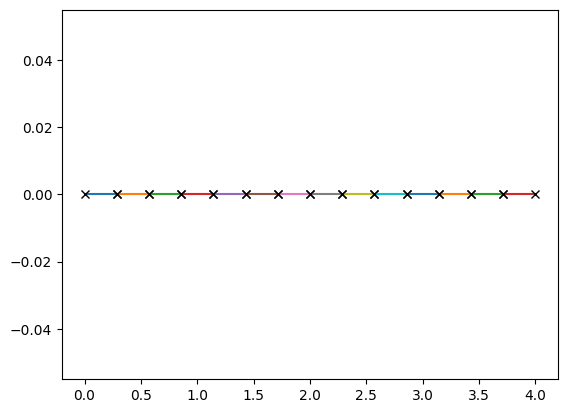

In [49]:
x_min = 0.0
x_max = 4.0
n_cells = 14

# Generate the mesh
vertices, cells = generate_mesh(x_min, x_max, n_cells)

# Plot the mesh
for cell in cells:
    plt.plot(vertices[cell], numpy.zeros(2), marker='x', markerfacecolor='k', markeredgecolor='k')

## 2D

4 5


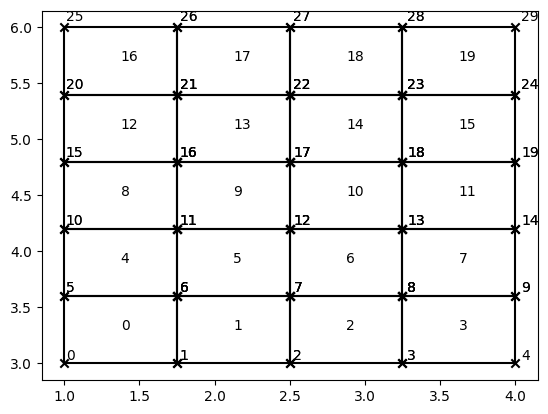

In [50]:
x_min = 1.0
x_max = 4.0
y_min = 3.0
y_max = 6.0
n_cells_x = 4
n_cells_y = 5

# Generate the mesh
vertices, cells, h_x, h_y = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y)

# Plot the mesh
for cell_idx, cell in enumerate(cells):
    # Plot the vertices of the mesh
    plt.scatter(vertices[cell, 0], vertices[cell, 1], marker='x', c='k')
    # Add the numbers of the vertices
    for v_idx in cell:
        plt.text(vertices[v_idx, 0]*1.01, vertices[v_idx, 1]*1.01, '{v_idx}'.format(v_idx=v_idx))

    # Plot the edges of the mesh
    vertex_order_plot = numpy.array([0, 1, 3, 2, 0])
    plt.plot(vertices[cell[vertex_order_plot], 0], vertices[cell[vertex_order_plot], 1], '-k')
    # Add the numbers of the elements
    v_mean = vertices[cell, :].mean(axis=0)  # compute the mean point of the cell
    plt.text(v_mean[0], v_mean[1], '{cell_idx}'.format(cell_idx=cell_idx))

# Plot the local basis and their derivatives on the reference domain

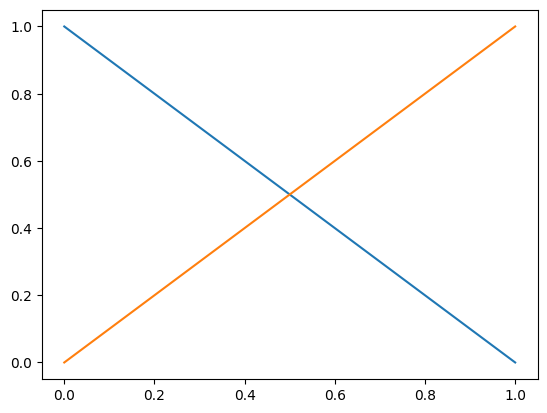

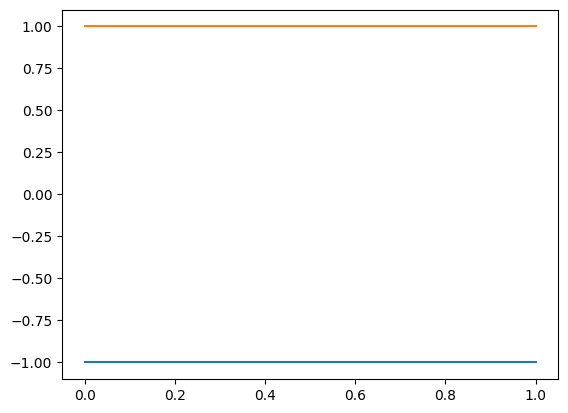

In [51]:
xi = numpy.linspace(0, 1, 100)

# Evaluate the basis
B_local_basis = evaluate_local_basis_1D(xi)
B_local_basis_d_dx = evaluate_local_basis_1D_d_dx(xi)

# Plot the bases
plt.figure()
for basis in B_local_basis:
    plt.plot(xi, basis)

# Plot the derivatives of the bases
plt.figure()
for basis_d_dx in B_local_basis_d_dx:
    plt.plot(xi, basis_d_dx)

# Plot the global basis and their derivative

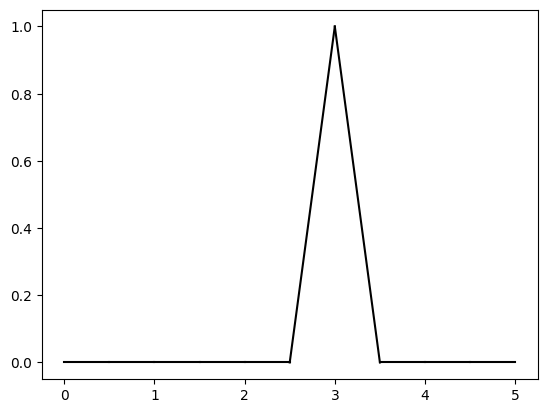

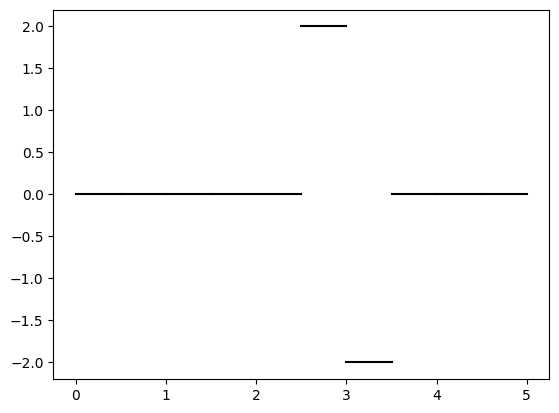

In [52]:
x_min = 0.0
x_max = 5.0
n_cells = 10
n_points_per_cell = 2  # since the bases are linear, we just need to evaluate them at two points on each cell
basis_idx = 6  # the index of the basis, not that this must be an int in the range (0, n_elements)

# Generate the mesh
vertices, cells = generate_mesh(x_min, x_max, n_cells)

# Evaluate the basis
n_vertices = n_cells + 1
B_basis_coefficients = numpy.zeros(n_vertices)
B_basis_coefficients[basis_idx] = 1  # the k-basis is just a function with coefficients zero everywhere except for the index k
B_basis_eval, x_eval = evaluate_function(B_basis_coefficients, vertices, cells, n_points_per_cell = n_points_per_cell)

# Plot the basis
plt.figure()
plt.plot(x_eval.T, B_basis_eval.T, 'k')

# Evaluate the derivative
B_basis_eval_d_dx, x_eval = evaluate_function_d_dx(B_basis_coefficients, vertices, cells, n_points_per_cell = n_points_per_cell)

# Plot the derivative of the basis
plt.figure()
plt.plot(x_eval.T, B_basis_eval_d_dx.T, 'k')

# Solve the Poisson equation with the functions introduced
Note that we follow an equivalent, but different approach of including the boundary conditions.

We construct the stiffness matrix $\boldsymbol{\mathsf{N}}$ for all the basis (including the ones at the boundary). We then replace the first and last rows by the identity vectors, i.e., $[1, 0, \dots, 0]$ and $[0, \dots, 0, 1]$, respectively. And we change the right hand side to $\left(\boldsymbol{\mathsf{f}}_{bc}\right)_{0} = \phi_{a}$ and $\left(\boldsymbol{\mathsf{f}}_{bc}\right)_{n} = \phi_{b}$.

We leave as an exercise to show that this is identical to the original formulation.

The reason for doing it in this way is simplicity.

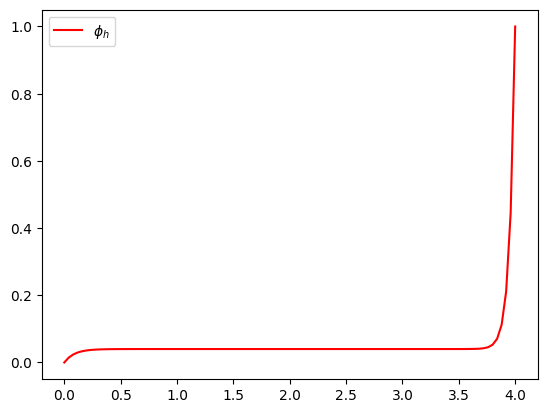

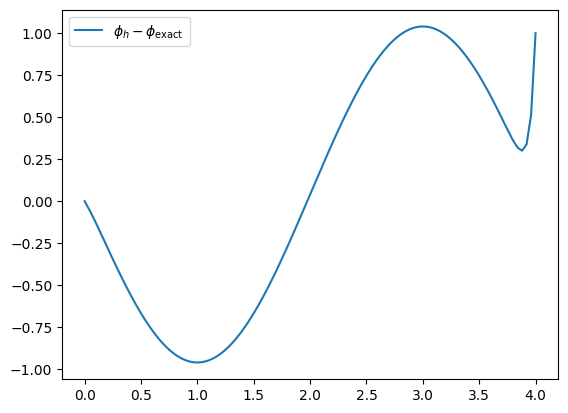

In [104]:
x_min = 0.0
x_max = 4.0
n_cells = 100
n_points_per_cell = 2  # since the bases are linear, we just need to evaluate them at two points on each cell
basis_idx = 6  # the index of the basis, not that this must be an int in the range (0, n_elements)

solution_choice = 0  # 0: parabola homogeneous boundary conditions
                     # 1: parabola inhomogeneous boundary conditions
                     # 2: sin
                      
# Setup the exact solution phi and the right hand side f
if solution_choice == 0:
    #phi = lambda x: x * (5.0 - x)  # exact parabola solution with homogeneous boundary conditions
    f = lambda x: numpy.ones_like(x) #2.0 * numpy.ones_like(x)  # right hand side of Poisson equation

elif solution_choice == 1:
    phi = lambda x: x * (5.0 - x) + x + 1  # exact parabola solution with inhomogeneous boundary conditions
    f = lambda x: 2.0 * numpy.ones_like(x)  # right hand side of Poisson equation

elif solution_choice == 2:
    #phi = lambda x: numpy.sin(0.5*numpy.pi * x)  # exact parabola solution with inhomogeneous boundary conditions
    f = lambda x: numpy.ones_like(x) #((0.5*numpy.pi)**2) * numpy.sin(0.5*numpy.pi * x)  # right hand side of Poisson equation

# Impose essential (Dirichlet) boundary conditions
phi_x_min = phi(x_min)
phi_x_max = phi(x_max)

# Generate the mesh
vertices, cells = generate_mesh(x_min, x_max, n_cells)

# Compute global stiffness matrix
S_global = compute_global_stiffness_matrix(vertices, cells)
M_global = compute_global_mass_matrix(vertices, cells)
u =1
epsilon = 0.1
delta_h = (x_max - x_min) / n_cells
N_global = u/2* S_global - epsilon/delta_h * M_global

# Compute the right hand side
F = compute_forcing_term(f, vertices, cells)

# Include the boundary conditions
N_global[0, :] = 0.0
N_global[0, 0] = 1.0
N_global[-1, :] = 0.0
N_global[-1, -1] = 1.0
F[0] = 0 #phi_x_min
F[-1] = 1 #phi_x_max

# Solve the system
phi_h = scipy.linalg.solve(N_global, F)

# Plot the numerical solution and the exact solution for comparison
x_exact_plot = numpy.linspace(x_min, x_max, 1001)
phi_exact = phi(x_exact_plot)

plt.figure()
#plt.plot(x_exact_plot, phi_exact, 'k', label=r'$\phi_{\mathrm{exact}}$')
plt.plot(vertices, phi_h, 'red', label=r'$\phi_{h}$')
plt.legend()

# Plot the error
phi_h_error, x_error = evaluate_function(phi_h, vertices, cells, n_points_per_cell = 100)
phi_exact_error = phi(x_error)

plt.figure()
plt.plot(x_error.flatten(), (phi_h_error - phi_exact_error).flatten(), label=r'$\phi_{h} - \phi_{\mathrm{exact}}$')
plt.legend()

# Solve the definite Helmholtz equation
You can see that we can easily address another PDE with the building blocks we constructed.

In [105]:
x_min = 0.0
x_max = 5.0
n_cells = 10
n_points_per_cell = 2  # since the bases are linear, we just need to evaluate them at two points on each cell
basis_idx = 6  # the index of the basis, not that this must be an int in the range (0, n_elements)

solution_choice = 2  # 0: parabola homogeneous boundary conditions
                     # 1: parabola inhomogeneous boundary conditions
                     # 2: sin
                      
# Setup the exact solution phi and the right hand side f
if solution_choice == 0:
    phi = lambda x: x * (5.0 - x)  # exact parabola solution with homogeneous boundary conditions
    f = lambda x: 2.0 * numpy.ones_like(x) + x * (5.0 - x)  # right hand side of Poisson equation

elif solution_choice == 1:
    phi = lambda x: x * (5.0 - x) + x + 1  # exact parabola solution with inhomogeneous boundary conditions
    f = lambda x: 2.0 * numpy.ones_like(x) + x * (5.0 - x) + x + 1  # right hand side of Poisson equation

elif solution_choice == 2:
    phi = lambda x: numpy.sin(0.5*numpy.pi * x)  # exact parabola solution with inhomogeneous boundary conditions
    f = lambda x: ((0.5*numpy.pi)**2) * numpy.sin(0.5*numpy.pi * x) + numpy.sin(0.5*numpy.pi * x)  # right hand side of Poisson equation

# Impose essential (Dirichlet) boundary conditions
phi_x_min = phi(x_min)
phi_x_max = phi(x_max)

# Generate the mesh
vertices, cells = generate_mesh(x_min, x_max, n_cells)

# Compute global stiffness matrix
N_global = compute_global_stiffness_matrix(vertices, cells)
N_global.toarray()

# Compute global mass matrix
M_global = compute_global_mass_matrix(vertices, cells)
M_global.toarray()

# Sum the two into a single matrix
S_global = M_global + N_global

# Compute the right hand side
F = compute_forcing_term(f, vertices, cells)

# Include the boundary conditions
S_global[0, :] = 0.0
S_global[0, 0] = 1.0
S_global[-1, :] = 0.0
S_global[-1, -1] = 1.0
F[0] = phi_x_min
F[-1] = phi_x_max

# Solve the system
phi_h = scipy.sparse.linalg.spsolve(S_global, F)

# Plot the numerical solution and the exact solution for comparison
x_exact_plot = numpy.linspace(x_min, x_max, 1001)
phi_exact = phi(x_exact_plot)

plt.figure()
plt.plot(x_exact_plot, phi_exact, 'k', label=r'$\phi_{\mathrm{exact}}$')
plt.plot(vertices, phi_h, 'red', label=r'$\phi_{h}$')
plt.legend()

# Plot the error
phi_h_error, x_error = evaluate_function(phi_h, vertices, cells, n_points_per_cell = 100)
phi_exact_error = phi(x_error)

plt.figure()
plt.plot(x_error.flatten(), (phi_h_error - phi_exact_error).flatten(), label=r'$\phi_{h} - \phi_{\mathrm{exact}}$')
plt.legend()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

# Solve 2D Homogeneous Poisson equation

In [ ]:
def compute_S_local(u_x, u_y, epsilon, h_x, h_y):
    BIxBK = numpy.array([[-0.5, -0.5], [0.5, 0.5]])
    BIBK = numpy.array([[0.25, 0.75], [0.75, 0.25]])
    #print(numpy.kron(BIxBK, h_y*BIBK))#,"\n",numpy.kron(h_x*BIBK, BIxBK))
    #print(h_x, h_y)#, 1/h_x, 1/h_y, h_x*BIBK, h_y*BIBK, 1/h_x * BIxBK, 1/h_y * BIxBK)
    #print(numpy.kron(1/h_x * BIxBK, h_y*BIBK).shape, numpy.kron(h_x*BIBK, 1/h_y * BIxBK).shape)
    S_1 = - u_x * numpy.kron(BIxBK, h_y*BIBK) - u_y * numpy.kron(h_x*BIBK, BIxBK)

    BIxBKx = numpy.array([[1.0, -1.0], [-1.0, 1.0]])
    S_2 = epsilon * (numpy.kron(1/h_x * BIxBKx, h_y*BIBK) + numpy.kron(h_x*BIBK, 1/h_y * BIxBKx))
    return S_1 + S_2

def compute_S_global(u_x, u_y, epsilon, h_x, h_y, vertices, cells):
    S_global = numpy.zeros([vertices.shape[0], vertices.shape[0]])
    
    n_cells = cells.shape[0]
    for k in range(0, n_cells):
        cell = cells[k,:]

        S_local = compute_S_local(u_x, u_y, epsilon, h_x, h_y)
        for i in range(0, 4):
            for j in range(0, 4):
                S_global[cell[i], cell[j]] += S_local[i,j]
    
    return S_global





<>:33: SyntaxWarning: invalid escape sequence '\i'
<>:33: SyntaxWarning: invalid escape sequence '\i'
C:\Users\leolu\AppData\Local\Temp\ipykernel_13564\9807231.py:33: SyntaxWarning: invalid escape sequence '\i'
  """Computes the forcing term, right hand side, for the 2D mesh of vertices and cells.


40 41
(1722,)


ValueError: cannot reshape array of size 3444 into shape (42,41)

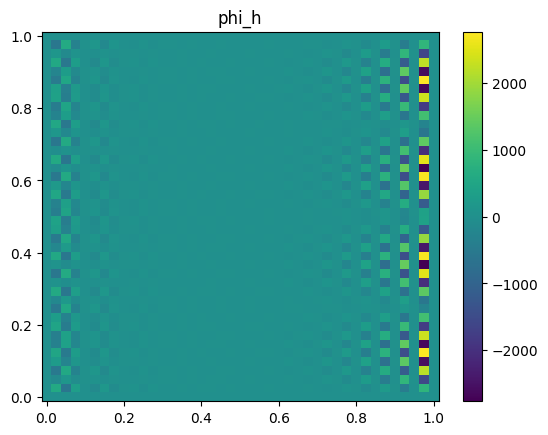

<Figure size 640x480 with 0 Axes>

In [ ]:
x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0
n_cells_x = 40
n_cells_y = 41

solution_choice = 0  # 0: f(x,y) = 8*pi*pi*sin(2*pi*x)*sin(2*pi*y) and homogeneous boundary conditions
                      
# Setup the exact solution phi and the right hand side f
if solution_choice == 0:
    #phi = lambda point: numpy.sin(2.0*numpy.pi*point[:, 0])*numpy.sin(2.0*numpy.pi*point[:, 1])  # exact parabola solution with homogeneous boundary conditions
    f = lambda point: 1 if point < 0.5 else -1        #-8.0*numpy.pi*numpy.pi*numpy.sin(2.0*numpy.pi*point[:, 0])*numpy.sin(2.0*numpy.pi*point[:, 1])  # right hand side of Poisson equation

# Impose essential (Dirichlet) boundary conditions
phi_left = 0.0
phi_right = 0.0
phi_bottom = 0.0
phi_top = 0.0

# Generate the mesh
vertices, cells, h_x, h_y = generate_mesh_2D(x_min, x_max, y_min, y_max, n_cells_x, n_cells_y)

# Compute global stiffness matrix
N_global = compute_global_stiffness_matrix_2D(vertices, cells)
N_global.toarray()

# Setup the global system matrix
S = compute_S_global(0, 1, 0.01, h_x, h_y, vertices, cells)   # this is not efficient but is to make it explicit (we need the "-"" sign because we performed integration by parts)


def compute_forcing_term_2D(f, vertices, cells):
    """Computes the forcing term, right hand side, for the 2D mesh of vertices and cells.

    The forcing term F is
        F[j] = \int_{\Omega} f(x, y) B_{j}(x, y) dxdy
    
    With B_{j}(x, y) the global basis function i over the domain.
        
    Parameters
    ----------
    f : func
        The function implementing the right hand side function of the Poisson or Helmholtz equations.
    vertices : numpy.array(float), size [n+1, 1]
        The x- and y-coordinates of the vertices of the mesh. The index in the array is
        the index of the vertex, i.e., vertices[k, :] is the x- and y-coordinate of the
        k-th vertex of the mesh.
    cells : numpy.array(int), size [n, 4]
        The indices of the start and end vertex of each cell, i.e.,
        cells[k, 0] is the lower left vertex of the k-th cell
        cells[k, 1] is the lower right vertex of the k-th cell
        cells[k, 2] is the upper left vertex of the k-th cell
        cells[k, 3] is the upper right vertex of the k-th cell

    Returns
    -------
    F : numpy.array(float), size [n+1]
        The forcing term with F[j] ~= \int_{\Omega} f(x, y) B_{j}(x, y) dxdy
    """
    n_cells = cells.shape[0]
    n_vertices = vertices.shape[0]
    delta_x = (vertices[cells[:, 1], 0] - vertices[cells[:, 0], 0]).flatten()
    delta_y = (vertices[cells[:, 2], 1] - vertices[cells[:, 0], 1]).flatten()

    F = numpy.zeros(n_vertices)
    Fplot = numpy.zeros(n_vertices)
    for cell_idx, cell in enumerate(cells):
        f_at_cell_vertices = f(vertices[cell_idx][0])
        Fplot[cell_idx] = f_at_cell_vertices
        F[cell] += 0.25 * f_at_cell_vertices * delta_x[cell_idx] * delta_y[cell_idx]
    #plt.plot(Fplot)
    #plt.show()
    return F

# Compute the right hand side
F = compute_forcing_term_2D(f, vertices, cells)

# Include the boundary conditions
# Left boundary
i_idx = numpy.zeros(n_cells_y + 1, dtype=numpy.int64)
j_idx = numpy.arange(0, n_cells_y + 1)
left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
S[left_basis_indices, :] = 0.0
for basis_idx in left_basis_indices:
    S[basis_idx, basis_idx] = 1.0
    F[basis_idx] = phi_left  # note that phi_left is contant, if not, this needs to be changed

# Right boundary
i_idx = n_cells_x*numpy.ones(n_cells_y + 1, dtype=numpy.int64)
j_idx = numpy.arange(0, n_cells_y + 1)
left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
S[left_basis_indices, :] = 0.0
for basis_idx in left_basis_indices:
    S[basis_idx, basis_idx] = 1.0
    F[basis_idx] = phi_right  # note that phi_right is contant, if not, this needs to be changed

# Bottom boundary
i_idx = numpy.arange(0, n_cells_x + 1)
j_idx = numpy.zeros(n_cells_x + 1, dtype=numpy.int64)
left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
S[left_basis_indices, :] = 0.0
for basis_idx in left_basis_indices:
    S[basis_idx, basis_idx] = 1.0
    F[basis_idx] = phi_bottom  # note that phi_bottom is contant, if not, this needs to be changed

# Top boundary
i_idx = numpy.arange(0, n_cells_x + 1)
j_idx = n_cells_y*numpy.ones(n_cells_x + 1, dtype=numpy.int64)
left_basis_indices = i_idx + (n_cells_x + 1)*j_idx
S[left_basis_indices, :] = 0.0
for basis_idx in left_basis_indices:
    S[basis_idx, basis_idx] = 1.0
    F[basis_idx] = phi_top  # note that phi_top is contant, if not, this needs to be changed

# Solve the system 
phi_h = scipy.linalg.solve(S, F)
print(phi_h.shape)

# Check correctness
phi_exact = phi(vertices)  # compute the exact solution at the nodes
plt.figure()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), phi_h.reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.colorbar()
plt.title("phi_h")
plt.figure()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), phi_exact.reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.colorbar()
plt.title("phi_exact")
plt.figure()
plt.pcolormesh(vertices[:, 0].reshape(n_cells_y+1, n_cells_x+1), vertices[:, 1].reshape(n_cells_y+1, n_cells_x+1), (phi_h - phi_exact).reshape(n_cells_y+1, n_cells_x+1))  # plot the error
plt.colorbar()
plt.title("phi_h - phi_exact")